### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
from PIL import Image

%matplotlib inline

In [2]:
articles = pd.read_csv('articles.csv')
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
customers = pd.read_csv('customers.csv')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [4]:
transactions = pd.read_csv('transactions_train.csv', parse_dates=['t_dat'])
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


### Non-personalised

In [5]:
from datetime import timedelta

In [6]:
def non_personalised(k, n, data):
    transactions = data.copy()
    df = transactions[transactions.t_dat > transactions.t_dat.max()-timedelta(days=n)]
    df = df.groupby('article_id')['t_dat'].count().reset_index()
    df.columns = ['article_id', 'no_of_times_sold']
    df = df.sort_values('no_of_times_sold', ascending = False)
    df_topk = df[:k].reset_index(drop = True)
    
    return df_topk

### Data Preprocessing

In [7]:
def split_train_test(n, data):
    trans = data.copy()
    transactions_ndays = data[data.t_dat > data.t_dat.max()-timedelta(days=n)]
    test_data = transactions_ndays
    trans.drop(trans.tail(len(transactions_ndays)).index, inplace = True)
    train_data = trans
    return train_data, test_data

In [8]:
def remove_new_customers(data1, data2):
    cust_list1 = list(data1['customer_id'].unique())
    cust_list2 = list(data2['customer_id'].unique())
    for customer in cust_list1:
        if customer not in cust_list2:
            data1 = data1.drop(labels=data1[data1['customer_id'] == customer].index)
    return data1

In [9]:
import random

def downsize(data, n):
    random.seed(42)
    unique_cust_ids = list(data['customer_id'].unique())
    sample_cust_ids = random.sample(unique_cust_ids, n)
    downsized_data = data[data['customer_id'].isin(sample_cust_ids)]
    return downsized_data

In [10]:
def filter_training_data(n, data):
    trans = data.copy()
    transactions_nmonths = trans[trans.t_dat > trans.t_dat.max()-timedelta(days=n*30)]
    return transactions_nmonths

Splitting the data into Training and Testing data

In [11]:
filtered_train_data = filter_training_data(6.25, transactions)
filtered_train_data

,t_dat,customer_id,article_id,price,sales_channel_id
23523980,2020-03-19,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,554450042,0.033881,2
23523981,2020-03-19,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,706016006,0.023712,2
23523982,2020-03-19,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,706016019,0.033881,2
23523983,2020-03-19,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,706016019,0.033881,2
23523984,2020-03-19,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,856797002,0.059305,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [12]:
train, test = split_train_test(7, filtered_train_data)

In [13]:
no_cust = 1000

In [14]:
#test_data_1000 = downsize(test, 1000)
test_data_1000 = downsize(test, no_cust)
test_data_1000

,t_dat,customer_id,article_id,price,sales_channel_id
31548155,2020-09-16,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,923340001,0.016932,1
31548156,2020-09-16,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,923340001,0.016932,1
31548218,2020-09-16,01bd99ffb52a7ede83ef062e65b3959f7317a4fd225506...,664074001,0.010153,1
31548450,2020-09-16,03d708693a2dec4cc72d12e568383c356a0ad201d651f7...,803757005,0.016932,2
31548451,2020-09-16,03d708693a2dec4cc72d12e568383c356a0ad201d651f7...,904567001,0.025407,2
...,...,...,...,...,...
31787493,2020-09-22,f8dea2bb1152f6ea01635f130f914454d5ddfa5bfda99e...,685813037,0.016932,2
31787494,2020-09-22,f8dea2bb1152f6ea01635f130f914454d5ddfa5bfda99e...,922625003,0.025407,2
31787882,2020-09-22,fc453ef5d7f22f05ff890b39b018d353b3464c42fc8167...,865929007,0.016932,2
31787883,2020-09-22,fc453ef5d7f22f05ff890b39b018d353b3464c42fc8167...,574109042,0.025407,2


In [15]:
test_data_without_new_cust = remove_new_customers(test, filtered_train_data)
test_data_without_new_cust

,t_dat,customer_id,article_id,price,sales_channel_id
31548013,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,786022008,0.048441,2
31548014,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,913272003,0.032288,2
31548015,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,889669006,0.056508,2
31548016,2020-09-16,0010e8eb18f131e724d6997909af0808adbba057529edb...,237347060,0.033881,1
31548017,2020-09-16,0010e8eb18f131e724d6997909af0808adbba057529edb...,562245001,0.013542,1
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [16]:
#test_data_without_new_cust_1000 = downsize(test_data_without_new_cust, 1000)
test_data_without_new_cust_1000 = downsize(test_data_without_new_cust, no_cust)
test_data_without_new_cust_1000

,t_dat,customer_id,article_id,price,sales_channel_id
31548155,2020-09-16,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,923340001,0.016932,1
31548156,2020-09-16,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,923340001,0.016932,1
31548218,2020-09-16,01bd99ffb52a7ede83ef062e65b3959f7317a4fd225506...,664074001,0.010153,1
31548450,2020-09-16,03d708693a2dec4cc72d12e568383c356a0ad201d651f7...,803757005,0.016932,2
31548451,2020-09-16,03d708693a2dec4cc72d12e568383c356a0ad201d651f7...,904567001,0.025407,2
...,...,...,...,...,...
31787493,2020-09-22,f8dea2bb1152f6ea01635f130f914454d5ddfa5bfda99e...,685813037,0.016932,2
31787494,2020-09-22,f8dea2bb1152f6ea01635f130f914454d5ddfa5bfda99e...,922625003,0.025407,2
31787882,2020-09-22,fc453ef5d7f22f05ff890b39b018d353b3464c42fc8167...,865929007,0.016932,2
31787883,2020-09-22,fc453ef5d7f22f05ff890b39b018d353b3464c42fc8167...,574109042,0.025407,2


#### Converting test data into dictionary of customers and articles

In [17]:
test_df = test_data_1000.copy()
test_df['article_id'] = test_df['article_id'].astype(str) + ' '
test_df = pd.DataFrame(test_df.groupby('customer_id').article_id.sum())

In [18]:
test_df_idx = test_data_1000.copy()
test_df_idx['article_id'] = test_df_idx['article_id'].astype(str) + ' '
test_df_idx = pd.DataFrame(test_df_idx.groupby('customer_id').article_id.sum()).reset_index()

In [19]:
test_dict = test_df.to_dict()
test_dict = test_dict['article_id']
test_dict
for i in test_dict:
    lst = test_dict[i][:-1].split(' ')
    lst_n = [int(x) for x in lst]
    test_dict[i] = lst_n
    
test_dict

{'00d50aaf75f46e2975bd23a9283d098b34a087e9281255dfbf117cadd6ca302d': [754362020,
  572998013],
 '00e80d504a6043b8b588f118b9bf97d73daeed6d3f68b136a50ee7c6de9712cf': [785018003,
  821152002],
 '00f0157f63bfd27503a760c86b610d9e3ea63e67351aa0d03c71b174f98e4d75': [456163086,
  715624001,
  456163085],
 '00fb1d75af5bdbea71936c004adaef008c5dd8820c83536b6e41f20d45a62aa2': [909371001,
  877961005,
  877961006,
  807244017],
 '012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1d13e0c79f9e0faf867': [923340001,
  923340001],
 '01b23ba97032e4bec41c944fa5817555cbaa9ded6e29958f295ee47d7d50c964': [749699002,
  871519007,
  749699032,
  749699001,
  749699031],
 '01b6edb7dc80c6de6eba7fc8c59eb5213e473fbc21d423ed8e395fd3e205f831': [831547001],
 '01bd99ffb52a7ede83ef062e65b3959f7317a4fd2255061117c03bd739844242': [664074001],
 '01d295dca7617ee57a998830c7313478a8bcfab18e9e97452b543bd4f8ae12f1': [923758001,
  866731001,
  924243002],
 '01e22d4e4660310c56bbe51eeb74f7275a87798f55eacbeab326d9a201d2ff6b': [933989002]

In [20]:
test_df_without_new_cust = test_data_without_new_cust_1000.copy()
test_df_without_new_cust['article_id'] = test_df_without_new_cust['article_id'].astype(str) + ' '
test_df_without_new_cust = pd.DataFrame(test_df_without_new_cust.groupby('customer_id').article_id.sum())

In [21]:
test_df_without_new_cust_idx = test_data_without_new_cust_1000.copy()
test_df_without_new_cust_idx['article_id'] = test_df_without_new_cust_idx['article_id'].astype(str) + ' '
test_df_without_new_cust_idx = pd.DataFrame(test_df_without_new_cust_idx.groupby('customer_id').article_id.sum()).reset_index()

In [22]:
test_dict_without_new_cust = test_df_without_new_cust.to_dict()
test_dict_without_new_cust = test_dict_without_new_cust['article_id']

for i in test_dict_without_new_cust:
    lst = test_dict_without_new_cust[i][:-1].split(' ')
    lst_n = [int(x) for x in lst]
    test_dict_without_new_cust[i] = lst_n
    
test_dict_without_new_cust

{'00d50aaf75f46e2975bd23a9283d098b34a087e9281255dfbf117cadd6ca302d': [754362020,
  572998013],
 '00e80d504a6043b8b588f118b9bf97d73daeed6d3f68b136a50ee7c6de9712cf': [785018003,
  821152002],
 '00f0157f63bfd27503a760c86b610d9e3ea63e67351aa0d03c71b174f98e4d75': [456163086,
  715624001,
  456163085],
 '00fb1d75af5bdbea71936c004adaef008c5dd8820c83536b6e41f20d45a62aa2': [909371001,
  877961005,
  877961006,
  807244017],
 '012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1d13e0c79f9e0faf867': [923340001,
  923340001],
 '01b23ba97032e4bec41c944fa5817555cbaa9ded6e29958f295ee47d7d50c964': [749699002,
  871519007,
  749699032,
  749699001,
  749699031],
 '01b6edb7dc80c6de6eba7fc8c59eb5213e473fbc21d423ed8e395fd3e205f831': [831547001],
 '01bd99ffb52a7ede83ef062e65b3959f7317a4fd2255061117c03bd739844242': [664074001],
 '01d295dca7617ee57a998830c7313478a8bcfab18e9e97452b543bd4f8ae12f1': [923758001,
  866731001,
  924243002],
 '01e22d4e4660310c56bbe51eeb74f7275a87798f55eacbeab326d9a201d2ff6b': [933989002]

#### Converting training data into dictionary of customers and articles

In [23]:
train_df = filtered_train_data.copy()
train_df['article_id'] = train_df['article_id'].astype(str) + ' '
train_df = pd.DataFrame(train_df.groupby('customer_id').article_id.sum())

In [24]:
train_df

,article_id
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,841260003 887593002 890498002 795440001 859416...
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,599580055 599580055 811835004 811835004 811835...
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,727808001 727808007 858883002 851400006 750424...
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,589440005 827971001 818320001 896152002 730683...
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,719530003 448509014
...,...
ffff8f9ecdce722b5bab97fff68a6d1866492209bfe5242c50d2a10a652fb5ef,859845001 889679001 863001002
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,826955010 826955010 797565001 822344003 557599...
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,687034024 739590040 879891001 739819009 816597...


In [25]:
train_dict = train_df.to_dict()
train_dict = train_dict['article_id']
for i in train_dict:
    lst = train_dict[i][:-1].split(' ')
    lst_n = [int(x) for x in lst]
    train_dict[i] = lst_n
    
train_dict

{'00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657': [841260003,
  887593002,
  890498002,
  795440001,
  859416011,
  568601043],
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa': [599580055,
  599580055,
  811835004,
  811835004,
  811835004,
  811835004,
  723529001,
  559630026,
  599580083,
  811927004,
  811927004,
  811925005,
  811925005,
  351484002,
  826211002],
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318': [727808001,
  727808007,
  858883002,
  851400006,
  750424014,
  750424014,
  870304002,
  870304002,
  852643001,
  852643003,
  794321007],
 '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a': [589440005,
  827971001,
  818320001,
  896152002,
  730683050,
  927530004,
  791587015],
 '0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a': [719530003,
  448509014],
 '00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2': [666444002,
  349301041,
  721257001,
  160442010,
  

#### Creating dictionary of product codes and articles

In [26]:
articles_product_code_df = articles.copy()
articles_product_code_df['article_id'] = articles_product_code_df['article_id'].astype(str) + ' '
articles_product_code_df = pd.DataFrame(articles_product_code_df.groupby(
    'product_code').article_id.sum())


In [27]:
articles_product_code_dict = articles_product_code_df.to_dict()
articles_product_code_dict = articles_product_code_dict['article_id']

In [28]:
for i in articles_product_code_dict:
    lst = articles_product_code_dict[i][:-1].split(' ')
    lst_n = [int(x) for x in lst]
    articles_product_code_dict[i] = lst_n
#articles_product_code_dict

In [29]:
art_prod_code = articles[['article_id', 'product_code']].set_index('product_code')
art_same_prod_code = pd.merge(art_prod_code, articles_product_code_df, left_index=True, right_index=True)
art_same_prod_code = art_same_prod_code.reset_index(drop=True)
art_same_prod_code.columns = ['article_id', 'product_code_articles']
art_same_prod_code

,article_id,product_code_articles
0,108775015,108775015 108775044 108775051
1,108775044,108775015 108775044 108775051
2,108775051,108775015 108775044 108775051
3,110065001,110065001 110065002 110065011
4,110065002,110065001 110065002 110065011
...,...,...
105537,953450001,953450001
105538,953763001,953763001
105539,956217002,956217002
105540,957375001,957375001


In [30]:
art_same_prod_code.product_code_articles = art_same_prod_code.product_code_articles.apply(lambda x: [int(i) for i in x[:-1].split(' ')])

In [31]:
clean_articles_product_code = []
for article_id, product_code_articles in zip(art_same_prod_code['article_id'].values, art_same_prod_code['product_code_articles'].values):
    #print(article_id)
    #print(product_code_articles)
    if (article_id in product_code_articles):
        #print(article_id)
        product_code_articles.remove(article_id)
    else:
        product_code_articles = []
    #print(product_code_articles)
    clean_articles_product_code.append(product_code_articles)
art_same_prod_code.product_code_articles = clean_articles_product_code

In [32]:
art_same_prod_code = art_same_prod_code.set_index('article_id')

In [33]:
art_same_prod_code_dict = art_same_prod_code.to_dict()
art_same_prod_code_dict = art_same_prod_code_dict['product_code_articles']

#### Creating dictionary of product types and articles

In [34]:
articles_product_type_df = articles.copy()
articles_product_type_df['article_id'] = articles_product_type_df['article_id'].astype(str) + ' '
articles_product_type_df = pd.DataFrame(articles_product_type_df.groupby(
    'product_type_no').article_id.sum())

In [35]:
articles_product_type_dict = articles_product_type_df.to_dict()
articles_product_type_dict = articles_product_type_dict['article_id']

In [36]:
art_prod_type = articles[['article_id', 'product_type_no']].set_index('product_type_no')
art_same_prod_type = pd.merge(art_prod_type, articles_product_type_df, left_index=True, right_index=True)
art_same_prod_type = art_same_prod_type.reset_index(drop=True)
art_same_prod_type.columns = ['article_id', 'product_type_articles']
art_same_prod_type

,article_id,product_type_articles
0,156224002,156224002 473954008 473954013 473954014 473954...
1,473954008,156224002 473954008 473954013 473954014 473954...
2,473954013,156224002 473954008 473954013 473954014 473954...
3,473954014,156224002 473954008 473954013 473954014 473954...
4,473954015,156224002 473954008 473954013 473954014 473954...
...,...,...
105537,874961004,874961001 874961002 874961003 874961004 874961...
105538,874961005,874961001 874961002 874961003 874961004 874961...
105539,852389001,852389001 852390001 852393001
105540,852390001,852389001 852390001 852393001


In [37]:
art_same_prod_type.product_type_articles = art_same_prod_type.product_type_articles.apply(lambda x: [int(i) for i in x[:-1].split(' ')])

In [38]:
clean_articles_product_type = []
for article_id, product_type_articles in zip(art_same_prod_type['article_id'].values, art_same_prod_type['product_type_articles'].values):
    #print(article_id)
    #print(product_code_articles)
    if (article_id in product_type_articles):
        #print(article_id)
        product_type_articles.remove(article_id)
    else:
        product_type_articles = []
    #print(product_code_articles)
    clean_articles_product_type.append(product_type_articles)
art_same_prod_type.product_type_articles = clean_articles_product_type

In [39]:
art_same_prod_type = art_same_prod_type.set_index('article_id')

In [40]:
art_same_prod_type_dict = art_same_prod_type.to_dict()
art_same_prod_type_dict = art_same_prod_type_dict['product_type_articles']

### Content-Based

In [53]:
def content_based(n, k, train_df, data, art_same_prod_code, art_same_prod_type):
    recommendations = {}
    for cust in data:
        if (cust in list(train_df.keys())):
            article_ids = train_df[cust]

            if len(article_ids) >= n:
                article_ids = article_ids[-min(n,k):]
            #print(article_ids)
            
            no_recs_each_item = k//len(article_ids)
            no_extra_rec = k%len(article_ids)
            rec_list = []

            for a in article_ids:
                rec_article_ids = art_same_prod_code[a]
                if(len(rec_article_ids) < no_recs_each_item):
                    more_rec_article_ids = art_same_prod_type[a]
                
                    for i in more_rec_article_ids:
                        if i not in rec_article_ids:
                            rec_article_ids.append(i)
                
                rec_list += rec_article_ids[:no_recs_each_item]
                
            if(no_extra_rec != 0):
                extra_article_id = article_ids[-no_extra_rec:][0]
                rec_extra_article_ids = art_same_prod_code[extra_article_id]
                rec_extra_article_ids = rec_extra_article_ids[no_recs_each_item:no_recs_each_item+no_extra_rec]
                for r in rec_extra_article_ids:
                    rec_list.append(r)

            if(len(rec_list) < k):
                sub = k-len((rec_list))
                for i in range(sub):
                    rec_list.append(0)
            recommendations[cust]=rec_list
        else:
            recommendations[cust]=[0]*k 
    
    return recommendations

### User-Item Matrix

In [42]:
trans_df = filtered_train_data.copy()

In [43]:
ALL_USERS = trans_df['customer_id'].unique().tolist()
ALL_ITEMS = trans_df['article_id'].unique().tolist()
user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))
user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}
trans_df['user_id'] = trans_df['customer_id'].map(user_map)
trans_df['item_id'] = trans_df['article_id'].map(item_map)

In [44]:
train, test = split_train_test(7, trans_df)

In [45]:
user_item_df = train.groupby(['user_id', 'item_id'])['t_dat'].count().reset_index()
user_item_df = user_item_df.rename(columns = {'t_dat': 'purchase_count'})

In [46]:
values = user_item_df.purchase_count.values
row = user_item_df.user_id.values
column = user_item_df.item_id.values

In [47]:
from scipy.sparse import csr_matrix

In [48]:
sparse_user_item_matrix = csr_matrix((values, (row, column)), shape=(len(ALL_USERS), len(ALL_ITEMS)))

#### Importing ALS from Implicit Library

In [49]:
from implicit.als import AlternatingLeastSquares

In [50]:
model = AlternatingLeastSquares(factors=40, iterations=10, random_state=42)
model.fit(sparse_user_item_matrix)

c:\Users\baind\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


### ALS Recommendation

In [51]:
def als_recommend(n: int, cust_id_list: list, data: pd.DataFrame, sparse_matrix: object)->list:
    '''
    Uses ALS to generate recommendations for customers
    ---------------
    parameters:
        n: number of recommended items
        data: list of customer_ids
    '''
    recommendations = []
    for cust in cust_id_list:
        user_id = data[data['customer_id']==cust]['user_id'].array[0]
        item_ids = model.recommend(userid=user_id, N=n, user_items=sparse_matrix[user_id])[0]
        article_ids = []
        for item in item_ids:
            article_id = data[data['item_id']==item]['article_id'].array[0]
            article_ids.append(article_id)
        recommendations.append(article_ids)
    return recommendations

### Hybrid Recommendation

In [68]:
def hybrid_recommendation(k, cust_id_list, filtered_train_data, data, trans_df, art_same_prod_code_dict, 
                          art_same_prod_type_dict, sparse_matrix):
    recommendations = []
    k_each_model = k//3
    extra = k%3
    #print(k_each_model)
    #print(extra)
    
    if(k_each_model != 0):
        np_recs = non_personalised(k_each_model, 7, filtered_train_data)
        np_recs_ids = list(np_recs['article_id'])
    #print(np_recs_ids)

    for cust in cust_id_list:
        np_recs_ids_ex=[]
        cb_recs_id=[]
        als_recs=[]
        if(k_each_model != 0):
            cb_recs = content_based(5, k_each_model, data, [cust], art_same_prod_code_dict, art_same_prod_type_dict)
            cb_recs_ids = []
            cb_recs_id = []
            for rec in cb_recs:
                cb_recs_ids.append(cb_recs[rec])
            for ids in cb_recs_ids:
                for i in ids:
                    cb_recs_id.append(int(i))
            cb_recs_id = cb_recs_id[:k_each_model]
            #print(cb_recs_id)
            
            als_recs = als_recommend(k_each_model, [cust], trans_df, sparse_matrix)[0]
            #print(als_recs)
        if (cust in list(data.keys())):
            als_recs.append(als_recommend(k_each_model+1, [cust], trans_df, sparse_matrix)[0][-1:][0])
            if (extra == 2):
                cb_recsx = content_based(5, k_each_model+1, data, [cust], art_same_prod_code_dict,
                                         art_same_prod_type_dict)
                new_cb_recs_ids = []
                for rec in cb_recsx:
                    new_cb_recs_ids.append(cb_recsx[rec])
                #print(new_cb_recs_ids[0][-1])
                cb_recs_id+=(new_cb_recs_ids[0][-1:])
                cb_recs_id = [int(x) for x in cb_recs_id]
                print(cb_recs_id)
        else:
            np_recs = non_personalised(k_each_model+extra, 7, data)
            np_recs_ids_ex.append(list(np_recs['article_id'])[-extra:])
            
        #print(als_recs)
        #print(np_recs_ids)
        recs = np_recs_ids +  cb_recs_id + als_recs + np_recs_ids_ex
        #print(cust)
        #print(recs)
        recommendations.append(recs)
    return recommendations

In [54]:
cust_id_list = list(test_dict.keys())

In [69]:
hybrid_recommendations = hybrid_recommendation(10, cust_id_list[:1], filtered_train_data, train_dict, trans_df, 
                                        art_same_prod_code_dict, art_same_prod_type_dict, sparse_user_item_matrix)

In [70]:
hybrid_recommendations

[[924243001,
  924243002,
  918522001,
  811500001,
  754362002,
  572998001,
  720125001,
  852174001,
  854043005,
  730683050]]

### Defining MAP

In [71]:
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

#Referred from: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

### Defining Average Precision

In [72]:
def avg_precision(actual, predicted):
    precision=0
    for act,pred in zip(actual, predicted):
        sum = 0
        for p in pred:
            if p in act:
                sum+=1.0
        precision+=(sum/len(pred))
        
    return precision/len(actual)

### Defining Average Recall

In [73]:
def avg_recall(actual, predicted):
    recall=0
    for act,pred in zip(actual, predicted):
        sum = 0
        for p in pred:
            if p in act:
                sum+=1.0
        recall+=(sum/len(act))
        
    return recall/len(actual)

### Evaluating Non-personalised recommendations

In [74]:
def non_personalised_multiple_recommendations(n, data, test_df):
    mapk_list=[]
    avg_precision_list=[]
    avg_recall_list=[]
    for k in range (1, 101):
        df_k_recommendations = non_personalised(k, n, data)

        #Creating list of predicted items
        np_recs = df_k_recommendations['article_id'].values
        recs = list(np_recs)
        p_list = []
        for i in range(len(test)):
            p_list.append(recs)
        
        #Creating list of actual items bought by the user
        articles_list = test_df['article_id'].to_list()
        a_list = []
        for a in articles_list:
            arr=a[:-1].split(' ')
            arr=[int(value) for value in arr]
            a_list.append(arr)

        
        mapk_list.append(mapk(a_list, p_list, k))
        avg_precision_list.append(avg_precision(a_list, p_list))
        avg_recall_list.append(avg_recall(a_list, p_list))

    return mapk_list, avg_precision_list, avg_recall_list

In [75]:
mapk_vals_np, avg_precision_vals_np, avg_recall_vals_np = non_personalised_multiple_recommendations(7, filtered_train_data, test_df)

In [76]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_np[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_np[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_np[val-1]))

MAP
k=10: 0.010394735449735449
k=50: 0.012623486109148934
k=100: 0.013488443391668931
Avg. Precision
k=10: 0.006999999999999994
k=50: 0.0047599999999999925
k=100: 0.0039799999999999775
Avg. Recall
k=10: 0.023413291985791986
k=50: 0.07053482886996049
k=100: 0.11649198398694528


In [77]:
mapk_vals_np_wnc, avg_precision_vals_np_wnc, avg_recall_vals_np_wnc = non_personalised_multiple_recommendations(7, filtered_train_data, test_df_without_new_cust)

In [78]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_np_wnc[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_np_wnc[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_np_wnc[val-1]))

MAP
k=10: 0.010394735449735449
k=50: 0.012623486109148934
k=100: 0.013488443391668931
Avg. Precision
k=10: 0.006999999999999994
k=50: 0.0047599999999999925
k=100: 0.0039799999999999775
Avg. Recall
k=10: 0.023413291985791986
k=50: 0.07053482886996049
k=100: 0.11649198398694528


### Evaluating Content-Based Recommendations

In [79]:
def content_based_multiple_recommendations(n, data, test_dict, test_df, articles_product_code_df, articles_product_type_df):
    mapk_list=[]
    avg_precision_list=[]
    avg_recall_list=[]
    for k in range (1, 101):
        cust_ids = list(test_dict.keys())
        content_based_recs = content_based(n, k, data, cust_ids, articles_product_code_df, articles_product_type_df)

        customer_ids = []
        recommended_article_ids = []
        for rec in content_based_recs:
            customer_ids.append(rec)
            recommended_article_ids.append(content_based_recs[rec])
        content_based_recommendations = pd.DataFrame(zip(customer_ids, recommended_article_ids))
        content_based_recommendations.columns = ['customer_id', 'recommended_article_id']

        actual_predicted_df = pd.merge(content_based_recommendations, test_df, on='customer_id')

        #Creating list of predicted items
        predicted_list = actual_predicted_df['recommended_article_id'].to_list()
        predicted = []
        for p in predicted_list:
            p_int=[int(value) for value in p]
            predicted.append(p_int)
        
        #Creating list of actual items bought by the user
        articles_list = test_df['article_id'].to_list()
        actual = []
        for a in articles_list:
            arr=a[:-1].split(' ')
            arr=[int(value) for value in arr]
            actual.append(arr)

        
        mapk_list.append(mapk(actual, predicted, k))
        avg_precision_list.append(avg_precision(actual, predicted))
        avg_recall_list.append(avg_recall(actual, predicted))

    return mapk_list, avg_precision_list, avg_recall_list
        


In [82]:
mapk_vals_cb, avg_precision_vals_cb, avg_recall_vals_cb = content_based_multiple_recommendations(5, train_dict, test_dict, test_df, art_same_prod_code_dict, art_same_prod_type_dict)

In [ ]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_cb[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_cb[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_cb[val-1]))

MAP
k=10: 0.030555555555555558
k=50: 0.0334920634920635
k=100: 0.029435376526571494
Avg. Precision
k=10: 0.02
k=50: 0.008
k=100: 0.004
Avg. Recall
k=10: 0.05
k=50: 0.1
k=100: 0.1


In [81]:
mapk_vals_cb_wnc, avg_precision_vals_cb_wnc, avg_recall_vals_cb_wnc = content_based_multiple_recommendations(5, train_dict, test_dict_without_new_cust, test_df_without_new_cust, art_same_prod_code_dict, art_same_prod_type_dict)

KeyboardInterrupt: 

In [ ]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_cb_wnc[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_cb_wnc[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_cb_wnc[val-1]))

MAP
k=10: 0.030555555555555558
k=50: 0.0334920634920635
k=100: 0.029435376526571494
Avg. Precision
k=10: 0.02
k=50: 0.008
k=100: 0.004
Avg. Recall
k=10: 0.05
k=50: 0.1
k=100: 0.1


### Evaluating ALS

In [66]:
def als_multiple_recommendations(data, test_df, user_item_matrix):
    mapk_list=[]
    avg_precision_list=[]
    avg_recall_list=[]
    for k in range (1,101):
        cust_list = list(set(test_df['customer_id'].to_list()))
        als_recommendations = als_recommend(k, cust_list, data, user_item_matrix)

        als_recommendations_df = pd.DataFrame(zip(cust_list, als_recommendations))
        als_recommendations_df.columns = ['customer_id', 'recommended_article_id']

        actual_predicted_df = pd.merge(als_recommendations_df, test_df, on='customer_id')

        #Creating list of predicted items
        predicted_list = actual_predicted_df['recommended_article_id'].to_list()
        predicted = []
        for p in predicted_list:
            p_int=[int(value) for value in p]
            predicted.append(p_int)
        
        #Creating list of actual items bought by the user
        articles_list = test_df['article_id'].to_list()
        actual = []
        for a in articles_list:
            arr=a[:-1].split(' ')
            arr=[int(value) for value in arr]
            actual.append(arr)

        
        mapk_list.append(mapk(actual, predicted, k))
        avg_precision_list.append(avg_precision(actual, predicted))
        avg_recall_list.append(avg_recall(actual, predicted))

    return mapk_list, avg_precision_list, avg_recall_list
        


In [69]:
mapk_vals_als, avg_precision_vals_als, avg_recall_vals_als = als_multiple_recommendations(trans_df, test_df_idx, sparse_user_item_matrix)

In [71]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_als[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_als[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_als[val-1]))

MAP
k=10: 0.0
k=50: 0.0
k=100: 0.0
Avg. Precision
k=10: 0.0
k=50: 0.0
k=100: 0.0
Avg. Recall
k=10: 0.0
k=50: 0.0
k=100: 0.0


In [72]:
mapk_vals_als_wnc, avg_precision_vals_als_wnc, avg_recall_vals_als_wnc = als_multiple_recommendations(trans_df, test_df_without_new_cust_idx, sparse_user_item_matrix)

In [73]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_als_wnc[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_als_wnc[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_als_wnc[val-1]))

MAP
k=10: 0.0
k=50: 0.0
k=100: 0.0
Avg. Precision
k=10: 0.0
k=50: 0.0
k=100: 0.0
Avg. Recall
k=10: 0.0
k=50: 0.0
k=100: 0.0


### Evaluating Hybrid Recommendations

In [108]:
def hybrid_multiple_recommendations(filtered_train_data, train_df, trans_df, test_df, articles_product_code_df, 
                                    articles_product_type_df, user_item_matrix):
    mapk_list=[]
    avg_precision_list=[]
    avg_recall_list=[]
    for k in range (1,101):
        cust_list = list(set(test_df['customer_id'].to_list()))
        hybrid_recommendations = hybrid_recommendation(k, cust_list, filtered_train_data, train_df, trans_df, 
                                                articles_product_code_df, articles_product_type_df, user_item_matrix)
        
        hybrid_recommendations_df = pd.DataFrame(zip(cust_list, hybrid_recommendations))
        hybrid_recommendations_df.columns = ['customer_id', 'recommended_article_id']

        actual_predicted_df = pd.merge(hybrid_recommendations_df, test_df, on='customer_id')

        #Creating list of predicted items
        predicted_list = actual_predicted_df['recommended_article_id'].to_list()
        predicted = []
        for p in predicted_list:
            p_int=[int(value) for value in p]
            predicted.append(p_int)
        
        #Creating list of actual items bought by the user
        articles_list = test_df['article_id'].to_list()
        actual = []
        for a in articles_list:
            arr=a[:-1].split(' ')
            arr=[int(value) for value in arr]
            actual.append(arr)

        
        mapk_list.append(mapk(actual, predicted, k))
        avg_precision_list.append(avg_precision(actual, predicted))
        avg_recall_list.append(avg_recall(actual, predicted))

    return mapk_list, avg_precision_list, avg_recall_list

In [ ]:
mapk_vals_hyb, avg_precision_vals_hyb, avg_recall_vals_hyb = hybrid_multiple_recommendations(filtered_train_data, 
                                                        train_dict, trans_df, test_df_idx, art_same_prod_code_dict, 
                                                        art_same_prod_type_dict, sparse_user_item_matrix)

In [ ]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_hyb[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_hyb[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_hyb[val-1]))

MAP
k=10: 0.03333333333333333
k=50: 0.03333333333333333
k=100: 0.03333333333333333
Avg. Precision
k=10: 0.01
k=50: 0.002
k=100: 0.001
Avg. Recall
k=10: 0.03333333333333333
k=50: 0.03333333333333333
k=100: 0.03333333333333333


In [ ]:
mapk_vals_hyb_wnc, avg_precision_vals_hyb_wnc, avg_recall_vals_hyb_wnc=hybrid_multiple_recommendations(filtered_train_data,
                                            train_df, trans_df, test_df_without_new_cust_idx, articles_product_code_df, 
                                                articles_product_type_df, sparse_user_item_matrix)

In [ ]:
k_list = [10, 50, 100]
print('MAP')
for val in k_list:
    print('k='+ str(val) +': '+str(mapk_vals_hyb_wnc[val-1]))
print('Avg. Precision')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_precision_vals_hyb_wnc[val-1]))
print('Avg. Recall')
for val in k_list:
    print('k='+ str(val) +': '+str(avg_recall_vals_hyb_wnc[val-1]))

MAP
k=10: 0.03333333333333333
k=50: 0.03333333333333333
k=100: 0.03333333333333333
Avg. Precision
k=10: 0.01
k=50: 0.002
k=100: 0.001
Avg. Recall
k=10: 0.03333333333333333
k=50: 0.03333333333333333
k=100: 0.03333333333333333


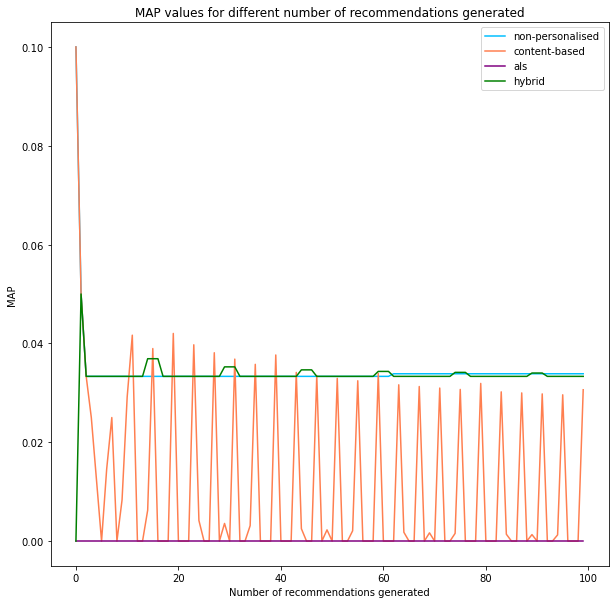

In [211]:
fig, ax1 = plt.subplots(figsize=(10,10))
plt.plot(mapk_vals_np, 'deepskyblue', label = 'non-personalised')
plt.plot(mapk_vals_cb, 'coral', label = 'content-based')
plt.plot(mapk_vals_als, 'purple', label = 'als')
plt.plot(mapk_vals_hyb, 'green', label = 'hybrid')
plt.legend(loc = 'upper right')
plt.xlabel('Number of recommendations generated')
plt.ylabel('MAP')
plt.title('MAP values for different number of recommendations generated')
plt.show()

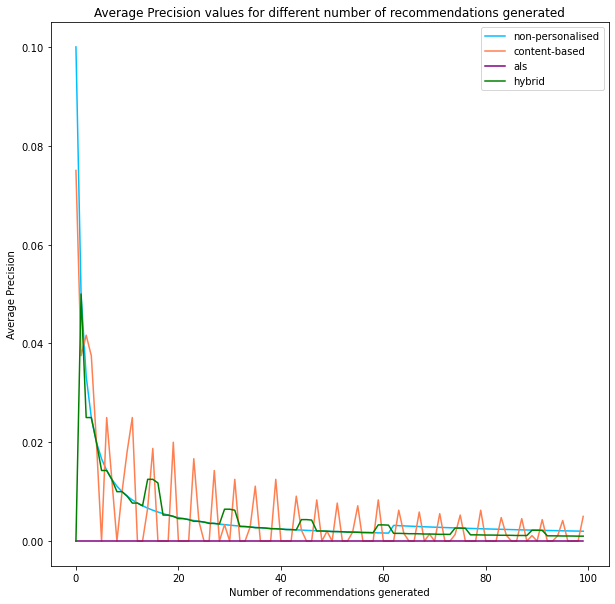

In [212]:
fig, ax1 = plt.subplots(figsize=(10,10))
plt.plot(avg_precision_vals_np, 'deepskyblue', label = 'non-personalised')
plt.plot(avg_precision_vals_cb, 'coral', label = 'content-based')
plt.plot(avg_precision_vals_als, 'purple', label = 'als')
plt.plot(avg_precision_vals_hyb, 'green', label = 'hybrid')
plt.legend(loc = 'upper right')
plt.xlabel('Number of recommendations generated')
plt.ylabel('Average Precision')
plt.title('Average Precision values for different number of recommendations generated')
plt.show()

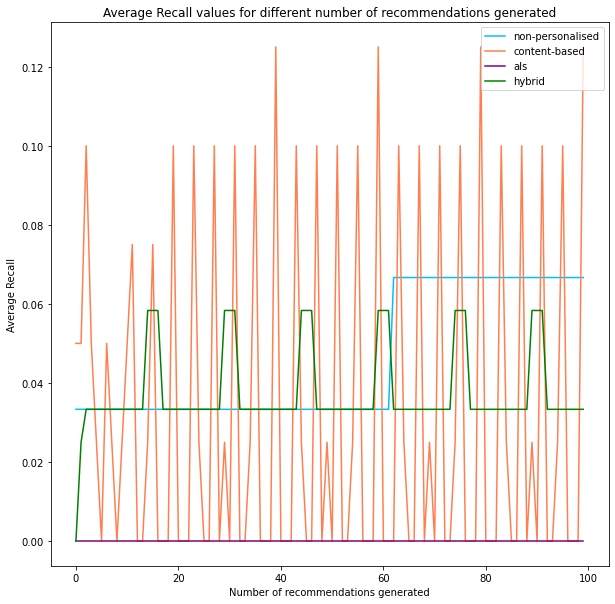

In [213]:
fig, ax1 = plt.subplots(figsize=(10,10))
plt.plot(avg_recall_vals_np, 'deepskyblue', label = 'non-personalised')
plt.plot(avg_recall_vals_cb, 'coral', label = 'content-based')
plt.plot(avg_recall_vals_als, 'purple', label = 'als')
plt.plot(avg_recall_vals_hyb, 'green', label = 'hybrid')
plt.legend(loc = 'upper right')
plt.xlabel('Number of recommendations generated')
plt.ylabel('Average Recall')
plt.title('Average Recall values for different number of recommendations generated')
plt.show()

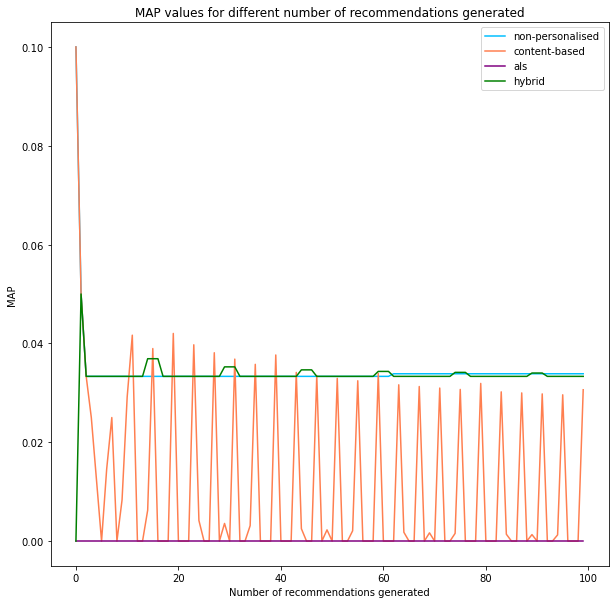

In [215]:
fig, ax1 = plt.subplots(figsize=(10,10))
plt.plot(mapk_vals_np_wnc, 'deepskyblue', label = 'non-personalised')
plt.plot(mapk_vals_cb_wnc, 'coral', label = 'content-based')
plt.plot(mapk_vals_als_wnc, 'purple', label = 'als')
plt.plot(mapk_vals_hyb_wnc, 'green', label = 'hybrid')
plt.legend(loc = 'upper right')
plt.xlabel('Number of recommendations generated')
plt.ylabel('MAP')
plt.title('MAP values for different number of recommendations generated')
plt.show()

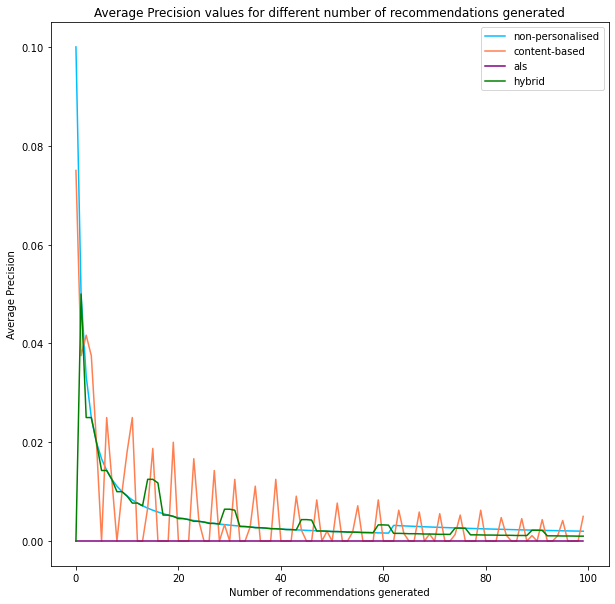

In [217]:
fig, ax1 = plt.subplots(figsize=(10,10))
plt.plot(avg_precision_vals_np_wnc, 'deepskyblue', label = 'non-personalised')
plt.plot(avg_precision_vals_cb_wnc, 'coral', label = 'content-based')
plt.plot(avg_precision_vals_als_wnc, 'purple', label = 'als')
plt.plot(avg_precision_vals_hyb_wnc, 'green', label = 'hybrid')
plt.legend(loc = 'upper right')
plt.xlabel('Number of recommendations generated')
plt.ylabel('Average Precision')
plt.title('Average Precision values for different number of recommendations generated')
plt.show()

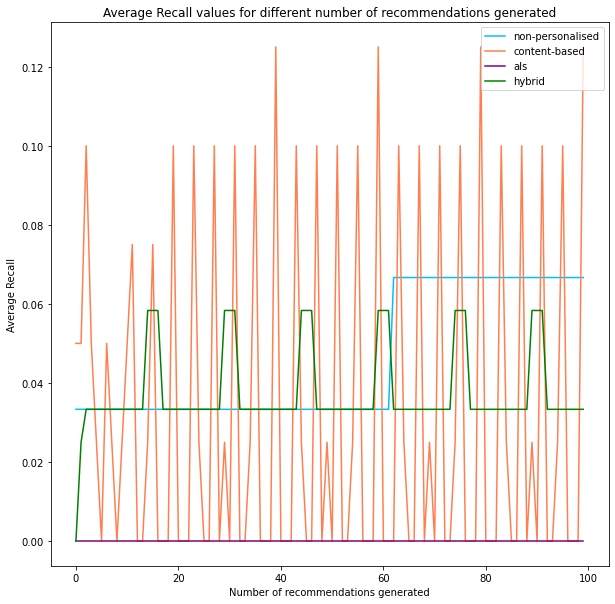

In [218]:
fig, ax1 = plt.subplots(figsize=(10,10))
plt.plot(avg_recall_vals_np_wnc, 'deepskyblue', label = 'non-personalised')
plt.plot(avg_recall_vals_cb_wnc, 'coral', label = 'content-based')
plt.plot(avg_recall_vals_als_wnc, 'purple', label = 'als')
plt.plot(avg_recall_vals_hyb_wnc, 'green', label = 'hybrid')
plt.legend(loc = 'upper right')
plt.xlabel('Number of recommendations generated')
plt.ylabel('Average Recall')
plt.title('Average Recall values for different number of recommendations generated')
plt.show()